In [1]:
%load_ext autoreload

In [2]:
autoreload 2

In [3]:
import sys
# !{sys.executable} -m pip install -r ../../requirements.txt

In [4]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

helper_path = os.path.abspath(os.path.join('../helper'))
if helper_path not in sys.path:
    sys.path.append(helper_path)

from helper.dataclass import HDDDataset
from helper.models.mymodel import MyModel
from helper.models.XCL import WeightedXCL
from helper.preprocessing import *
from helper.metrics import *
from helper.eda import *
from sklearn.model_selection import train_test_split
from helper.metrics import *
from helper.saver import Saver

## Data preprocessing

In [5]:
hdd_dataset = HDDDataset.read_csv('ST14000NM001G.csv')

In [6]:
preprocessor = Preprocessing(hdd_dataset)
preprocessor.clear_unused_data()
preprocessor.add_target_column()
preprocessor.prepare_train_df()
preprocessor.add_time_features()
preprocessor.train_test_val_split(sampling_strat=0.005, oversampling='Borderline')
preprocessor.normalize_data(method='formulae', inplace=True)
preprocessor.drop_unimportant_features(drop=13)
preprocessor.rescale_types()

Clearing unused columns...
Adding target column...
Prepairing train dataset...
Adding time features to unsplitted dataset...
Splitting train dataset...
Overampling with BorderlineSMOTE...


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\over_sampling\_smote\filter.py:197: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Normalizing splitted dataset with formulae...
    Удаляем не нужные признаки...     
failure 
diff_smart_5_raw_1 
diff_smart_242_raw_1 
diff_smart_240_raw_1 
diff_smart_199_raw_1 
diff_smart_9_raw_1 
diff_smart_241_raw_1 
shift_smart_9_raw_1 
shift_smart_242_raw_1 
shift_smart_241_raw_1 
shift_smart_240_raw_1 
smart_241_raw 
smart_9_raw 


## Training

In [7]:
model = WeightedXCL()
#model.fit(X_train, y_train)  # %%time
model.optimize_models_hyperparameters(preprocessor.X_train, preprocessor.y_train)
model.optimize_weights(preprocessor.X_val, preprocessor.y_val)
print(model.get_hyperparams())

=== Оптимизация гиперпараметров для XGBoost... ===
Лучшие параметры для XGBoost: {'colsample_bytree': 0.7334834444556088, 'gamma': 0.7143340896097039, 'learning_rate': 0.20526654188465587, 'max_depth': 7, 'n_estimators': 307, 'reg_alpha': 0.8609993861334124, 'reg_lambda': 0.9692763545078751, 'subsample': 0.5003893829205072}
=== Оптимизация гиперпараметров для CatBoost... ===
Лучшие параметры для CatBoost: {'bagging_temperature': 1.4439975445336495, 'border_count': 189, 'depth': 8, 'l2_leaf_reg': 1.0077876584101433, 'learning_rate': 0.30766346778736525, 'n_estimators': 210, 'random_strength': 1.1084844859190754}
=== Оптимизация гиперпараметров для LightGBM... ===
Лучшие параметры для LightGBM: {'colsample_bytree': 0.9464704583099741, 'learning_rate': 0.13022300234864176, 'max_depth': 10, 'min_child_samples': 12, 'n_estimators': 199, 'num_leaves': 72, 'reg_alpha': 0.9849549260809971, 'reg_lambda': 0.9162213204002109, 'subsample': 0.6061695553391381}
{'xgboost': {'objective': 'binary:logi

## Testing

In [8]:
preds = model.predict(preprocessor.X_test)
metrics = Metrics.get_metrics(preds, preprocessor.y_test)
print(metrics)

{'accuracy': 0.9997295141089813, 'precision': 0.9593023255813954, 'recall': 0.642023346303502, 'f1': 0.7692307692307693, 'auc_roc': 0.8210021037999242}


In [9]:
from sklearn.metrics import classification_report
print(classification_report(preprocessor.y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    365751
           1       0.96      0.64      0.77       257

    accuracy                           1.00    366008
   macro avg       0.98      0.82      0.88    366008
weighted avg       1.00      1.00      1.00    366008



## Logging

In [10]:
Saver.save(model, preprocessor, metrics, save_csv=False)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [11]:
lst1 = []
lst2 = []
lst3 = []
for name, imp in zip(preprocessor.X_test.columns, model.model_xgb.feature_importances_):
    lst1.append((name, round(imp, 3)))
for name, imp in zip(preprocessor.X_test.columns, model.model_cat.feature_importances_):
    lst2.append((name, round(imp, 3)))
for name, imp in zip(preprocessor.X_test.columns, model.model_lgbm.feature_importances_):
    lst3.append((name, imp))
print(sorted(lst1, key=lambda x: x[1]))
print(sorted(lst2, key=lambda x: x[1]))
print(sorted(lst3, key=lambda x: x[1]))

[('diff_smart_188_raw_1', 0.0), ('diff_smart_192_raw_1', 0.0), ('shift_smart_197_raw_1', 0.01), ('diff_smart_197_raw_1', 0.013), ('smart_240_raw', 0.014), ('smart_242_raw', 0.016), ('smart_192_raw', 0.018), ('shift_smart_192_raw_1', 0.023), ('shift_smart_5_raw_1', 0.029), ('shift_smart_199_raw_1', 0.032), ('smart_197_raw', 0.035), ('diff_smart_187_raw_1', 0.064), ('smart_199_raw', 0.074), ('shift_smart_188_raw_1', 0.092), ('shift_smart_187_raw_1', 0.1), ('smart_5_raw', 0.113), ('smart_188_raw', 0.179), ('smart_187_raw', 0.187)]
[('diff_smart_188_raw_1', 0.011), ('diff_smart_197_raw_1', 0.024), ('diff_smart_192_raw_1', 0.032), ('diff_smart_187_raw_1', 0.043), ('smart_197_raw', 0.141), ('shift_smart_197_raw_1', 0.213), ('shift_smart_187_raw_1', 0.301), ('shift_smart_5_raw_1', 0.338), ('smart_187_raw', 0.969), ('smart_5_raw', 1.243), ('shift_smart_199_raw_1', 1.968), ('smart_188_raw', 2.057), ('smart_199_raw', 2.418), ('shift_smart_188_raw_1', 4.468), ('smart_192_raw', 7.184), ('shift_sma

C:\Users\user\AppData\Local\Temp\ipykernel_9276\2005617931.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


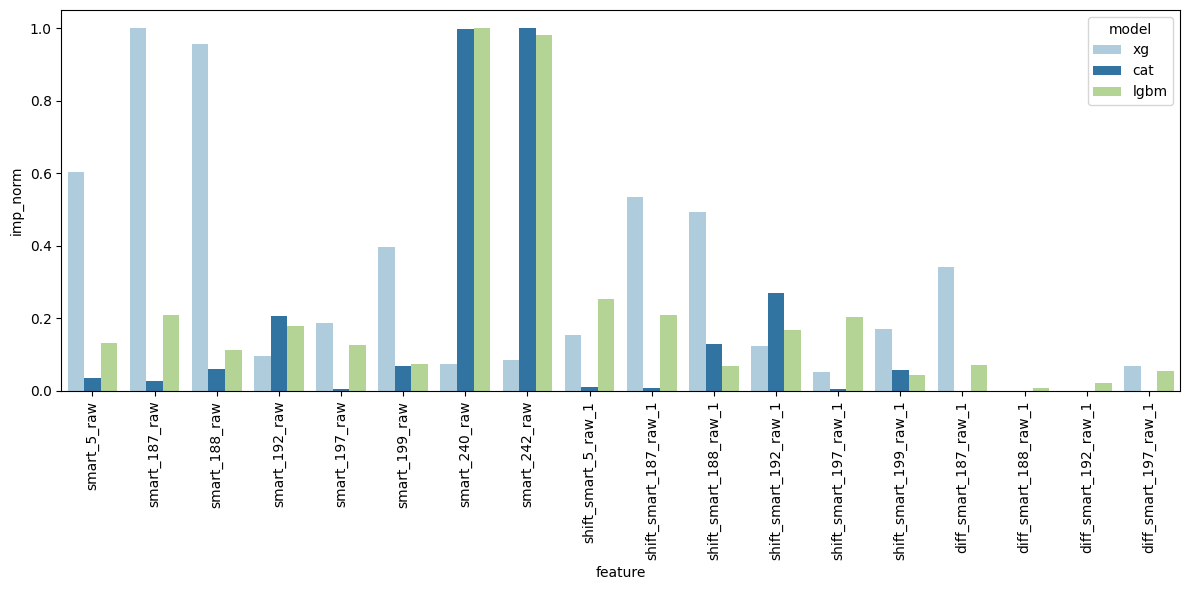

In [12]:
import seaborn as sns
data = []

for name, imp in zip(preprocessor.X_test.columns, model.model_xgb.feature_importances_):
    data.append({'model': 'xg', 'feature': name, 'imp': round(imp, 3)})
for name, imp in zip(preprocessor.X_test.columns, model.model_cat.feature_importances_):
    data.append({'model': 'cat', 'feature': name, 'imp': round(imp, 3)})
for name, imp in zip(preprocessor.X_test.columns, model.model_lgbm.feature_importances_):
    data.append({'model': 'lgbm', 'feature': name, 'imp': round(imp, 3)})
df = pd.DataFrame(data)
df['imp_norm'] = df.groupby('model')['imp'].transform(lambda x: x / x.max())
plt.figure(figsize=(12, 6))

ax = sns.barplot(x='feature', y='imp_norm', hue='model', data=df, palette='Paired')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()  # Чтобы избежать наложения текста
plt.show()